# A/A/B TESTING ANALYSIS

## Introduction

The purpose of this project is to identify which set of fonts produces better results. In order to come to a conclusion, we need to study the sales funnel and analyze an A/A/B test. 
We also need to find out how users reach the purchase stage, how many users actually make it to this stage, how many get stuck at previous stages and which stages in particular. 
The users are split into three groups: two control groups get the old fonts(246 and 247) and one test group(248) gets the new ones. 

### Contents

- Introduction
- Initialization
- Data preprocessing
    - Missing values
    - Dulicates
    - Correct data types
- Data Analysis
    - Study and check the data
    - Study the event funnel
    - Study the result of the experiment
        - Check whether the difference between the alpha groups, 246 and 247, is statistically significant
        - Check whether the difference between the alpha and beta groups, 246 and 248, is statistically significant
        - Check whether the difference between the alpha and beta groups, 247 and 248, is statistically significant
- General Conclusion

## Data Initialization

In [1]:
# load libraries
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import re
from scipy import stats as st
import math
import numpy as np

In [2]:
# load datset
log_data = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')

In [3]:
# print top rows of dataset
log_data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# change column names
log_data.columns = ['event_name', 'deviceID_hash', 'event_timestamp', 'expId']

### Data Preprocessing

In [5]:
# general info of dataframe
log_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   deviceID_hash    244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   expId            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


From the summary above, there are no missing values in the dataset.

In [6]:
# check for duplicates
log_data.duplicated().sum()

413

There are 413 duplicates in the dataset, we thus have to drop these rows.

In [7]:
# drop obvious duplicates
log_data.drop_duplicates(inplace = True)

In [8]:
# check for duplicates
log_data.duplicated().sum()

0

Now that the data has been preprocessed, we can continue on to distinguishing the timestamp to date and time.

In [9]:
# change timestamp column to date and time column
log_data['date_time'] = pd.to_datetime(log_data['event_timestamp'],unit='s')

In [10]:
# create column for dates
log_data['date'] = log_data['date_time'].dt.date

In [11]:
# change datatype to datetime
log_data['date'] = pd.to_datetime(log_data['date'])

In [12]:
# view data
log_data.head()

,event_name,deviceID_hash,event_timestamp,expId,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [13]:
# checking if users are in multiple groups
log_data[(log_data['expId'] == 246) & (log_data['expId'] == 247)]['deviceID_hash']

Series([], Name: deviceID_hash, dtype: int64)

In [14]:
# checking if users are in multiple groups
log_data[(log_data['expId'] == 246) & (log_data['expId'] == 248)]['deviceID_hash']

Series([], Name: deviceID_hash, dtype: int64)

In [15]:
# checking if users are in multiple groups
log_data[(log_data['expId'] == 247) & (log_data['expId'] == 248)]['deviceID_hash']

Series([], Name: deviceID_hash, dtype: int64)

In [16]:
# checking if users are in multiple groups
log_data[(log_data['expId'] == 246) & (log_data['expId'] == 247) & (log_data['expId'] == 248)]['deviceID_hash']

Series([], Name: deviceID_hash, dtype: int64)

Per the above series of filter queries, there are no users in multiple groups simultaneously. Every user represented in the dataset are in one distinct group each.

## Data Analysis

### Study and Check the Data

In [17]:
# view general info
log_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   deviceID_hash    243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   expId            243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


In [18]:
# count of unique events
log_data['event_name'].nunique()

5

In [19]:
# unique events
log_data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

There are 5 unique events in the log as seen above.

In [20]:
# count of unique users
log_data['deviceID_hash'].nunique()

7551

From over 200,000 logs, there are 7551 unique users recorded in the data.

In [21]:
# average number of events per user
user_event = log_data.groupby('date').agg({'deviceID_hash':'nunique','event_name':'count'}).reset_index()
user_event['avg_event_per_user'] = user_event['event_name']/user_event['deviceID_hash']
user_event = user_event.rename(columns={"deviceID_hash": "user_count", "event_name": "event_count"})
user_event

,date,user_count,event_count,avg_event_per_user
0,2019-07-25,7,9,1.285714
1,2019-07-26,22,31,1.409091
2,2019-07-27,39,55,1.410256
3,2019-07-28,69,105,1.521739
4,2019-07-29,135,184,1.362963
5,2019-07-30,296,412,1.391892
6,2019-07-31,924,2030,2.196970
7,2019-08-01,3703,36141,9.759924
8,2019-08-02,3647,35554,9.748835
9,2019-08-03,3482,33282,9.558300


In [22]:
# minimum datetime
log_data['date_time'].min()

Timestamp('2019-07-25 04:43:36')

In [23]:
# maximum datetime
log_data['date_time'].max()

Timestamp('2019-08-07 21:15:17')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


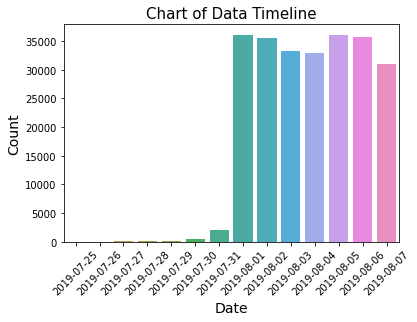

In [24]:
# histogram of date
sns.countplot(log_data['date'].dt.date)
plt.rcParams["figure.figsize"] = (10,6)
plt.rc('font', size=12)
plt.xlabel('Date', fontsize = 14)
plt.xticks(rotation = 45)
plt.ylabel('Count', fontsize = 14)
plt.title('Chart of Data Timeline', fontsize = 15)
plt.show()

The histogram above shows a negative skew as more lower-level data are abundant on the left side of the chart. The data starts to be more complete from 2019-07-31 compared to the data portrayed in the duration of 2019-07-25 to 2019-07-30. We can thus drop the incomplete data.

In [27]:
# filter out incomplete data
filter_log_data = log_data.query('date_time >= "2019-07-31"')

In [28]:
# checking count of users and events in filtered data
filter_log_data.groupby('date').agg({'deviceID_hash':'nunique','event_name':'count'})

,deviceID_hash,event_name
date,,
2019-07-31,924,2030
2019-08-01,3703,36141
2019-08-02,3647,35554
2019-08-03,3482,33282
2019-08-04,3527,32968
2019-08-05,3802,36058
2019-08-06,3922,35788
2019-08-07,3651,31096


From what we see above, we still have ample information on users and events in the filtered data.

In [29]:
# checking number of unique users in groups
filter_log_data.groupby('expId')['deviceID_hash'].nunique()

expId
246    2485
247    2517
248    2540
Name: deviceID_hash, dtype: int64

We also see the distribution of users in experimental groups is more than sufficient for our analysis.

We can now move on to the analysis of total events done by the unique users.

In [30]:
# number of events per user
filter_log_data.groupby(['deviceID_hash'])['event_name'].count().sort_values(ascending = False).reset_index()

,deviceID_hash,event_name
0,6304868067479728361,2307
1,197027893265565660,1998
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221
...,...,...
7537,2275878174127603404,1
7538,1083512226259476085,1
7539,5712952270342213514,1
7540,7524458840116781214,1


The largest number of events done by a single user is 2307. All users perform at least one event.

In [31]:
print('Number of logs filtered out is ', len(log_data) - len(filter_log_data),' out of ', len(log_data), ' logs.')
print('Share of logs fitered out: ', (len(log_data) - len(filter_log_data))/len(log_data) * 100)

Number of logs filtered out is  796  out of  243713  logs.
Share of logs fitered out:  0.326613680845913


Only 796 logs were filtered out of the data amounting to only 0.32% of the original dataset.

In [32]:
print('Number of users filtered out is ', log_data['deviceID_hash'].nunique() - filter_log_data['deviceID_hash'].nunique(), ' out of ', log_data['deviceID_hash'].nunique(), ' users.')
print('Share of users filtered out: ', ((log_data['deviceID_hash'].nunique()) - (filter_log_data['deviceID_hash'].nunique())) / log_data['deviceID_hash'].nunique() * 100)


Number of users filtered out is  9  out of  7551  users.
Share of users filtered out:  0.11918951132300357


And per the above output, only 9 users were filtered out of the data amounting to only about 0.12% of the original dataset.

### Study the Event Funnel

In [33]:
# events in order of frequency
filter_log_data['event_name'].value_counts()

MainScreenAppear           118578
OffersScreenAppear          46707
CartScreenAppear            42560
PaymentScreenSuccessful     34058
Tutorial                     1014
Name: event_name, dtype: int64

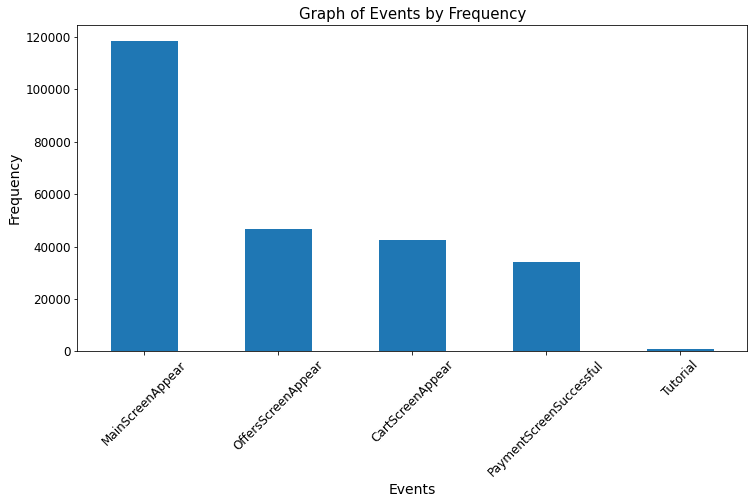

In [34]:
# graph of events by frequency
filter_log_data['event_name'].value_counts().plot(kind = 'bar')
plt.xlabel('Events', fontsize = 14)
plt.xticks(rotation = 45)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Graph of Events by Frequency', fontsize = 15)
plt.show()

The event "MainScreenAppear" is understandably the most frequent event as this is the first page or screen visitors access on the app.

In [35]:
# number of unique users that perform each event
filter_log_data.groupby('event_name')['deviceID_hash'].nunique().sort_values(ascending = False)

event_name
MainScreenAppear           7429
OffersScreenAppear         4606
CartScreenAppear           3742
PaymentScreenSuccessful    3542
Tutorial                    845
Name: deviceID_hash, dtype: int64

The order of events are the same as shown previously.

In [36]:
# share of users who perform each event
event_pct = filter_log_data.groupby('event_name')['deviceID_hash'].nunique().sort_values(ascending = False).reset_index()
event_pct['user_share'] = event_pct['deviceID_hash']/filter_log_data['deviceID_hash'].nunique() *100
event_pct

,event_name,deviceID_hash,user_share
0,MainScreenAppear,7429,98.501724
1,OffersScreenAppear,4606,61.071334
2,CartScreenAppear,3742,49.615487
3,PaymentScreenSuccessful,3542,46.963670
4,Tutorial,845,11.203925


Over 98% users encountered the Main screen compared with the Tutorial which only about 11% of the users partook in. This could be due to the use of a skip function which directly navigates the user from the Tutorial screen to the Main screen.

Now, we need to analyze the events performed by each unique user, those who performed at least 1 event and those who performed all the events.

In [37]:
# unique users who performed at least 1 event
filter_log_data.groupby(['deviceID_hash']).agg({'event_name':['unique','count']})

event_name      
                                                                unique count
deviceID_hash                                                               
6888746892508752                                    [MainScreenAppear]     1
6909561520679493     [MainScreenAppear, PaymentScreenSuccessful, Ca...     5
6922444491712477     [MainScreenAppear, PaymentScreenSuccessful, Ca...    47
7435777799948366                                    [MainScreenAppear]     6
7702139951469979     [MainScreenAppear, OffersScreenAppear, CartScr...   137
...                                                                ...   ...
9217594193087726423  [PaymentScreenSuccessful, CartScreenAppear, Of...     9
9219463515465815368  [MainScreenAppear, OffersScreenAppear, CartScr...    17
9220879493065341500  [MainScreenAppear, OffersScreenAppear, CartScr...     6
9221926045299980007                                 [MainScreenAppear]     7
9222603179720523844                                 [MainScreenAppear]    59

[7542 rows x 2 columns]

The above shows unique users, unique events they performed as well as total event count.

In [38]:
# pivot table of users who perform all events at least once
pd.options.display.max_colwidth = 210
test = filter_log_data.groupby(['deviceID_hash']).agg({'event_name':['unique','count']}).reset_index()
test.columns = ['userID','event_name','count']
test[test['event_name'].map(len) == 5]

,userID,event_name,count
7,9841258664663090,"[Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]",29
18,29094035245869447,"[Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]",24
57,77364241990273403,"[Tutorial, MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]",98
63,84107839139059565,"[Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]",52
66,89078601045475920,"[Tutorial, MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]",33
...,...,...,...
7459,9126019227179029392,"[Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]",31
7468,9132678164084161445,"[Tutorial, MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear]",21
7473,9141951425188555065,"[Tutorial, MainScreenAppear, CartScreenAppear, OffersScreenAppear, PaymentScreenSuccessful]",29
7488,9158074215019937335,"[Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful]",14


The table above shows unique users who perform every event as well as their cumulative event count.

In [39]:
# pivot table showing event counts per user
filter_log_data.pivot_table(index = 'deviceID_hash', columns = 'event_name', values = 'date', aggfunc = 'count', margins = True).dropna()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,All
deviceID_hash,,,,,,
9841258664663090,8.0,10.0,8.0,2.0,1.0,29
29094035245869447,2.0,10.0,10.0,1.0,1.0,24
77364241990273403,7.0,68.0,17.0,5.0,1.0,98
84107839139059565,7.0,17.0,20.0,6.0,2.0,52
89078601045475920,9.0,9.0,10.0,4.0,1.0,33
...,...,...,...,...,...,...
9132678164084161445,2.0,14.0,2.0,2.0,1.0,21
9141951425188555065,5.0,7.0,12.0,4.0,1.0,29
9158074215019937335,1.0,3.0,8.0,1.0,1.0,14


The table above shows the distribution of events performed per unique user.

In [40]:
# pivot table showing total events done by users per day
filter_log_data.pivot_table(index = 'date', columns = 'event_name', values = 'deviceID_hash', aggfunc = 'nunique', margins = True).sort_values(by = 'All', axis = 1, ascending = False)


event_name,All,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial
date,,,,,,
2019-07-31 00:00:00,924,649,238,193,118,8
2019-08-01 00:00:00,3703,3545,2050,1510,1372,155
2019-08-02 00:00:00,3647,3485,2070,1525,1394,145
2019-08-03 00:00:00,3482,3301,2072,1505,1413,143
2019-08-04 00:00:00,3527,3354,2085,1517,1424,130
2019-08-05 00:00:00,3802,3608,2151,1547,1447,99
2019-08-06 00:00:00,3922,3766,2167,1528,1454,118
2019-08-07 00:00:00,3651,3482,2062,1434,1361,69
All,7542,7429,4606,3742,3542,845


The table above shows count of unique users who performed each event per date.

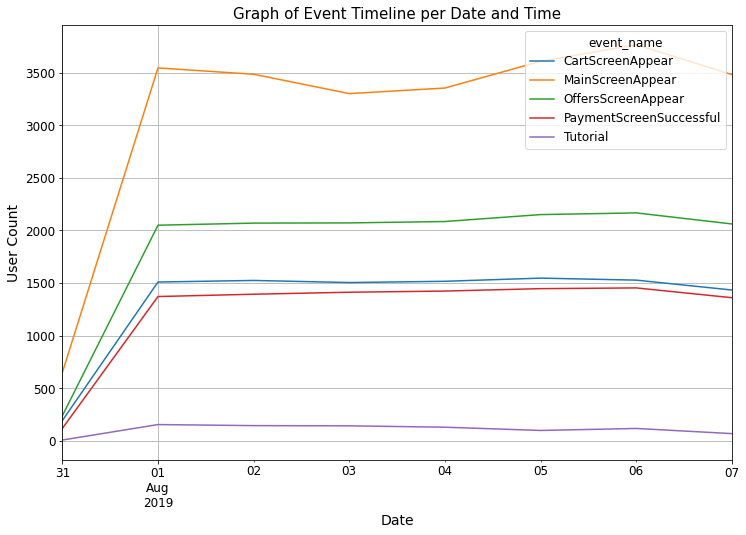

In [41]:
# graph showing sequence/frequency of events done by users daily
filter_log_data.pivot_table(index = 'date', columns = 'event_name', values = 'deviceID_hash', aggfunc = 'nunique').plot(figsize = (12,8), grid = True)
plt.xlabel('Date', fontsize = 14)
#plt.xticks(rotation = 45)
plt.ylabel('User Count', fontsize = 14)
plt.title('Graph of Event Timeline per Date and Time', fontsize = 15)
plt.show()

The graph above shows large distinctions among the frequency of events performed by users daily. Tutorial is the lowest on the spectrum while Main Screen Appear is the highest. We can see a sharp incline on the graph from July 31 to August 1 2019. From that point, the graph progresses on a steady line though the difference in user count among the events still remain.

Moving on to the event funnel analysis.

In [42]:
# table of events done by users per date and time
events = filter_log_data.pivot_table(index='deviceID_hash',columns='event_name',values='date_time',aggfunc='min')
events.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
deviceID_hash,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


The table above shows the events performed by unique users by the specified date and time. Per the 2nd and 3rd row, the timeline of events based on the date_time values is as follows: Main Screen -> Cart Screen -> Payment Screen -> Offers Screen, while the 5rd row is Cart Screen -> Payment Screen -> Main Screen -> Offers Screen. This shows that there are discrepancies with how the data timeline is collected or there are bugs affecting the application.

In [43]:
# funnel analysis of unique users who performed all events sequentially
step_1 = ~events['MainScreenAppear'].isna()
step_2 = step_1 & (events['OffersScreenAppear'] > events['MainScreenAppear'])
step_3 = step_2 & (events['CartScreenAppear'] > events['OffersScreenAppear'])
step_4 = step_3 & (events['PaymentScreenSuccessful'] > events['CartScreenAppear'])

n_mainscreen = events[step_1].shape[0]
n_offers = events[step_2].shape[0]
n_cart = events[step_3].shape[0]
n_payment = events[step_4].shape[0]

print('Users on main screen:', n_mainscreen)
print('Users on offers screen:', n_offers)
print('Users on cart screen:', n_cart)
print('Users at payment screen:', n_payment) 

Users on main screen: 7429
Users on offers screen: 4116
Users on cart screen: 1672
Users at payment screen: 453


In [44]:
# dataframe of funnel analysis on events per users
cols = ['event_name','user_count']
details = [['MainScreenAppear',n_mainscreen],
           ['OffersScreenAppear',n_offers],
           ['CartScreenAppear',n_cart],
           ['PaymentScreenSuccessful',n_payment],]
event_table = pd.DataFrame(data = details, columns = cols)
event_table

,event_name,user_count
0,MainScreenAppear,7429
1,OffersScreenAppear,4116
2,CartScreenAppear,1672
3,PaymentScreenSuccessful,453


In [45]:
# share of users who performed the events sequentially
event_table['share'] = event_table['user_count'].pct_change() * 100
event_table

,event_name,user_count,share
0,MainScreenAppear,7429,NaN
1,OffersScreenAppear,4116,-44.595504
2,CartScreenAppear,1672,-59.378037
3,PaymentScreenSuccessful,453,-72.906699


The Tutorial screen is not relevant to the analysis above so it was ignored.
From the Main screen to the Offers screen there was a loss of ~45% of users. From Offers screen to Cart screen -  a loss of 59% users. Finally from Cart screen to Payment screen, there was a massive loss of ~73% users. Therefore, the event with the most loss is the Payment screen.

From this result, I infer that the event funnel progresses as follows: Main Screen -> Offers Screen -> Cart Screen -> Payment Screen

In [46]:
#share of users who perform all events
test[test['event_name'].map(len) == 5].shape[0] / filter_log_data['deviceID_hash'].nunique() * 100

6.231768761601697

Only about 6% of the total users performed all 5 events. This is the share of users who make the entire journey from their first event to payment.

### Study the Results of the Experiment

In [47]:
# number of unique users in each group
filter_log_data.groupby('expId')['deviceID_hash'].nunique()

expId
246    2485
247    2517
248    2540
Name: deviceID_hash, dtype: int64

In [48]:
# pivot table of events performed by users in each group
group_pivot = filter_log_data.pivot_table(index = 'expId', columns = 'event_name', values = 'deviceID_hash', aggfunc = 'nunique', margins = True).sort_values(by = 'All', axis = 1, ascending = False)
group_pivot.drop(index = 'All', columns = 'All', inplace = True)
group_pivot

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial
expId,,,,,
246,2452,1544,1267,1200,278
247,2479,1526,1239,1159,285
248,2498,1536,1236,1183,282


In [49]:
# share of users who performed events per group
group_pivot/filter_log_data['deviceID_hash'].nunique() * 100

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial
expId,,,,,
246,32.511270,20.472023,16.799257,15.910899,3.686025
247,32.869265,20.233360,16.428003,15.367277,3.778839
248,33.121188,20.365951,16.388226,15.685495,3.739061


As expected based on our analysis above, MainScreenAppear is the most popular event performed by users in all 3 groups represented by about 33% of all users across the 3 groups.

Let us proceed with the analysis of the hypotheses.

**Hypotheses**

H0 (Null): The difference between both test groups based on the proportions of users at different funnel stages is not statistically significant

H1 (Alternative): The difference between both test groups based on the proportions of users at different funnel stages is statistically significant

In [50]:
def stat_difference(successes, trials):
    
    alpha = 0.05 # significance level

    # success proportion in the first group:
    p1 = successes[0]/trials[0]

    # success proportion in the second group:
    p2 = successes[1]/trials[1]

    # success proportion in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # the difference between the datasets' proportions
    difference = p1 - p2

    # calculating the statistic in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)
    # calculating the statistic in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        return "Null hypothesis rejected: the difference is statistically significant"

    else:
        return "Failed to reject the null hypothesis: we can't make conclusions about the difference"


In [51]:
# group pivot table with totals
group_with_total = filter_log_data.pivot_table(index = 'expId', columns = 'event_name', values = 'deviceID_hash', aggfunc = 'nunique', margins = True)
group_with_total.reset_index(inplace = True)

In [52]:
# view table
group_with_total

event_name,expId,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,All
0,246,1267,2452,1544,1200,278,2485
1,247,1239,2479,1526,1159,285,2517
2,248,1236,2498,1536,1183,282,2540
3,All,3742,7429,4606,3542,845,7542


In [53]:
# Main screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['MainScreenAppear'],group_with_total[group_with_total['expId'] == 247]['MainScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 247]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.58687768]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [54]:
# Offer screen - finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['OffersScreenAppear'],group_with_total[group_with_total['expId'] == 247]['OffersScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 247]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.2743506]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [55]:
# Cart screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['CartScreenAppear'],group_with_total[group_with_total['expId'] == 247]['CartScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 247]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.21306132]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [56]:
# Payment screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['PaymentScreenSuccessful'],group_with_total[group_with_total['expId'] == 247]['PaymentScreenSuccessful']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 247]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.11210845]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [57]:
# Tutorial screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['Tutorial'],group_with_total[group_with_total['expId'] == 247]['Tutorial']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 247]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.87916084]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

Based on our results above, we failed to reject the hypothesis as there is no conclusive evidence that the difference between the 2 alpha groups is statistically significant. This proves that the groups were properly split.


We will now determine if the difference between the alpha groups and the beta group, 246 and 248, is significantly significant.

In [58]:
# Main screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['MainScreenAppear'],group_with_total[group_with_total['expId'] == 248]['MainScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.34128639]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [59]:
# Offer screen - finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['OffersScreenAppear'],group_with_total[group_with_total['expId'] == 248]['OffersScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.2269968]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [60]:
# Cart screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['CartScreenAppear'],group_with_total[group_with_total['expId'] == 248]['CartScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.09941722]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

The above test failed to reject the null hypothesis because of the statistical significance level of 0.05. With a statistical significance level of 0.1, we could have achieved a false positive result as the p-value(0.09941722) is less than 0.1. So even if there are no significant diffrerences between the groups, we would have to reject the null hypothesis.

In [61]:
# Payment screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['PaymentScreenSuccessful'],group_with_total[group_with_total['expId'] == 248]['PaymentScreenSuccessful']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.22352232]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [62]:
# Tutorial screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 246]['Tutorial'],group_with_total[group_with_total['expId'] == 248]['Tutorial']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 246]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.92394674]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

The analysis between the 1st alpha group - 246 and the beta group - 248 gives the same result as that above of both alpha groups where we rejected the null hypothesis as we can't make conclusions about the difference between the groups.

We will now conduct analysis between the 2nd alpha group - 247 and the beta group - 248.

In [63]:
# Main screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 247]['MainScreenAppear'],group_with_total[group_with_total['expId'] == 248]['MainScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 247]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.68195838]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [64]:
# Offer screen - finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 247]['OffersScreenAppear'],group_with_total[group_with_total['expId'] == 248]['OffersScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 247]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.91005174]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [65]:
# Cart screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 247]['CartScreenAppear'],group_with_total[group_with_total['expId'] == 248]['CartScreenAppear']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 247]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.68837995]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [66]:
# Payment screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 247]['PaymentScreenSuccessful'],group_with_total[group_with_total['expId'] == 248]['PaymentScreenSuccessful']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 247]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.70658947]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

In [67]:
# Tutorial screen- finding statistical significance
sample1 = np.array([group_with_total[group_with_total['expId'] == 247]['Tutorial'],group_with_total[group_with_total['expId'] == 248]['Tutorial']])
         
sample2 = np.array([group_with_total[group_with_total['expId'] == 247]['All'],group_with_total[group_with_total['expId'] == 248]['All']])
         
stat_difference(sample1, sample2)

p-value:  [0.80363652]


"Failed to reject the null hypothesis: we can't make conclusions about the difference"

The results of the analysis are similar to the previous tests, the only difference is that the p-values are higher compared to those for the test between groups 246 and 248 and the test between the alpha groups - 246 and 247.


There were 15 tests conducted, so I chose 0.05 as the statistical significance level over 0.1 so as to avoid getting a false positive result as explained above for the outcome of the p-value for the Cart Screen test between groups 246 and 248.

## General Conclusion

From our preprocessing, there are no missing values in the dataset. There were 413 duplicates which were dropped as they were minimal in comparison to our total dataset with over 200,000 logs. There were 7551 unique users recorded in the data. There are also 3 test groups - A/A/B groups - of users in the log. The result of data queries on all 3 test groups indicates that there are no users in multiple groups simultaneously. Every user represented in the dataset are in one distinct group each.
There are 5 unique events in the log namely: 'MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear' and 'Tutorial'.

We created a histogram of user data per date and time which shows a negative skew as more lower-level data are abundant on the left side of the chart. The data starts to be more complete from 2019-07-31 compared to the data portrayed in the duration of 2019-07-25 to 2019-07-30. We thus dropped the incomplete data.

The event "MainScreenAppear" is understandably the most frequent event as this is the first page or screen visitors access on the app. Over 98% users encountered the Main screen compared with the Tutorial which only about 11% of the users partook in. This could be due to the use of a skip function which directly navigates the user from the Tutorial screen to the Main screen. The same can be said about users in the groups as the event "MainScreenAppear" accounts for about 33% of all users for each of the 3 groups while "Tutorial" accounts for just under 4% of all users per group.

We also created a graph which shows large distinctions among the frequency of events performed by users daily. Tutorial is the lowest on the spectrum while Main Screen Appear is the highest. There was a sharp incline on the graph from July 31 to August 1 2019. From that point, the graph progresses on a steady line though the difference in user count among the events still remain.

Based on the data showing the events performed by users based on date and time, there were different resulting timelines of event progression which shows that there are discrepancies with how the data timeline is collected or there are bugs affecting the application.

The Tutorial screen is not relevant to our analysis so it was ignored. From the Main screen to the Offers screen there was a loss of ~45% of users. From Offers screen to Cart screen - a loss of 59% users. Finally from Cart screen to Payment screen, there was a massive loss of ~73% users. Therefore, the event with the most loss is the Payment screen.

From this, we can infer that the event funnel progresses as follows: Tutorial -> Main Screen -> Offers Screen -> Cart Screen -> Payment Screen

Only about 6% of the total users performed all 5 events. This is the share of users who make the entire journey from their first event to payment.

Lastly, for all our statistical tests, we failed to reject the hypothesis as there were no conclusive evidence that the difference between the 3 groups are statistically significant. We can thus infer that the groups were properly split.

There were 15 tests conducted, so I chose 0.05 as the statistical significance level over 0.1 so as to avoid getting a false positive result. This is because for the outcome of the p-value for the Cart Screen test between groups 246 and 248, we failed to reject the null hypothesis because of the statistical significance level of 0.05. With a statistical significance level of 0.1, we could have achieved a false positive result as the p-value(0.09941722) is less than 0.1. So even if there are no significant differences between the groups, we would have to reject the null hypothesis.

Based on our analysis and results of the hypotheses tests, there was no conclusive difference amongst any of the test groups so we can determine that the implementation of a new font system in the application will not have much of an impact on the users and can thus be approved.